In [3]:
%matplotlib inline

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import sklearn
from sklearn import datasets
import torch
import cvxopt
import pyomo.environ as pe

# Visualization code

In [3]:
def draw_contour(ax, f, xlow, xhigh, ylow, yhigh):
    x,y = np.meshgrid(np.arange(xlow, xhigh, 0.1), np.arange(ylow, yhigh, 0.1))
    #Slow loop
    z = np.zeros(np.shape(x))
    for i in np.arange(0, np.shape(x)[0]):
        for j in np.arange(0, np.shape(x)[1]):
            z[i,j] = f(np.array((x[i,j],y[i,j])))
    ax.contour(x,y,z, levels=10, alpha=0.2)
    
def draw_search_path(ax, steps):
    linecoll = mpl.collections.LineCollection(zip(steps[:-1], steps[1:]), colors='r')
    linecoll.set_linestyle('-')
    ax.add_collection(linecoll)
    ax.scatter(steps[0][0], steps[0][1], marker='s', c='r') #Start point
    ax.scatter(steps[-1][0], steps[-1][1], marker='*', c='b') #End point
    ax.scatter([pos[0] for pos in steps[1:-1]], [pos[1] for pos in steps[1:-1]], marker='.', c = 'r') #Middle points


def illustrate_search(ax, f, steps, xlow, xhigh, ylow, yhigh):
    print("Iteration sequence:")
    print(steps)
    draw_contour(ax, f, xlow, xhigh, ylow, yhigh)
    draw_search_path(ax, steps)

In [4]:
class QuadraticObjective(object):
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
    
    def value(self, p):
        return 0.5 * np.dot(p, np.dot(self.a, p)) + np.dot(self.b, p) + self.c
    
    def grad(self, p):
        return np.dot(self.a, p) + self.b
    
    def hess(self, p):
        return self.a

Algorithms
=========

In [5]:
def fake_algorithm():
    return [[-2,0],[-1,-1],[3,-1]]

Algorithm tests
==============

In [6]:
simple_quad_obj = QuadraticObjective(np.eye(2), np.array([-2.0, 4.0]), 5.0)
stretched_quad_obj = QuadraticObjective(np.array([[10.0,-1.0],[-1.0, 2.0]]), np.array([3.0, 3.0]), 2.0)

Iteration sequence:
[[-2, 0], [-1, -1], [3, -1]]


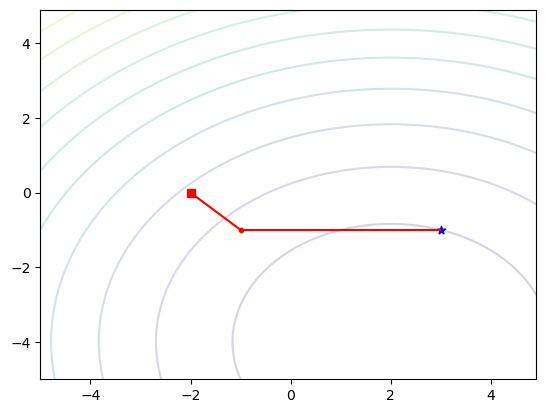

In [7]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, simple_quad_obj.value, fake_algorithm(), -5, 5, -5, 5)
plt.draw()
plt.show()

Iteration sequence:
[[-2, 0], [-1, -1], [3, -1]]


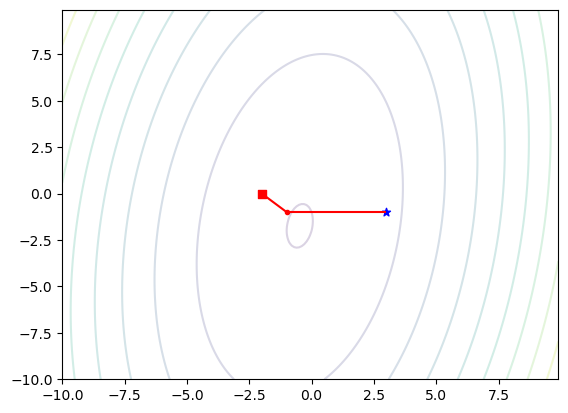

In [8]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, stretched_quad_obj.value, fake_algorithm(), -10, 10, -10, 10)
plt.draw()
plt.show()

# Gradient descent and Newton's Method

In [9]:
def simple_stop_crit(points, step_dir, tolerance = 1e-2):
    return np.linalg.norm(step_dir) <= tolerance

def backtracking(f, grad, x, d, init_step = 1.0, dec = 0.1, contraction=0.4):
    orig_val = f(x)
    orig_grad = grad(x)
    step = init_step
    while f(x  + step * d) > orig_val + dec * step * np.dot(orig_grad, d):
        step *= contraction
        if step < 1e-20:
            raise 'Backtracking failed'
    return step


def descent_method(x_init, dir_finder, size_finder, stop_crit):
    points = [x_init]
    cont = True
    
    x = x_init
    while cont:
        step_dir = dir_finder(x)
        if stop_crit(points, step_dir):
            cont = False
        step_size = size_finder(x, step_dir)
        x = x + step_size*step_dir
        
        points.append(x)

    return points

def steepest_descent(f, grad, x_0):
    return descent_method(x_0,
                          lambda x : -grad(x),
                          lambda x, d : backtracking(f, grad, x, d),
                          lambda ps, x: simple_stop_crit(ps, x))

def newton(f, grad, hess, x_0):
    return descent_method(x_0,
                          lambda x : -np.linalg.solve(hess(x), grad(x)),
                          lambda x, d : backtracking(f, grad, x, d),
                          lambda ps, x: simple_stop_crit(ps, x))

### Steepest Descent

Iteration sequence:
[array([-2.,  0.]), array([ 2., -4.]), array([ 2., -4.])]


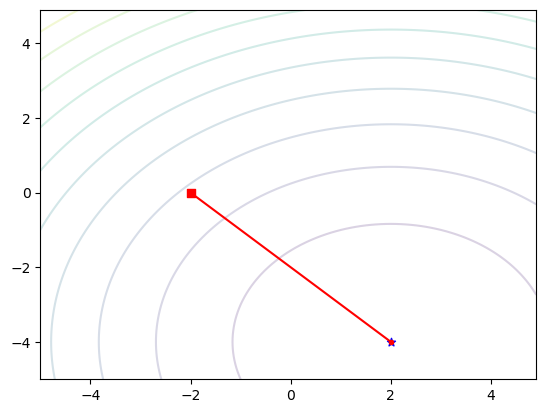

In [10]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, simple_quad_obj.value, 
                  steepest_descent(simple_quad_obj.value, simple_quad_obj.grad, np.array([-2.0,0.0])),
                  -5, 5, -5, 5)

Iteration sequence:
[array([-2.,  4.]), array([1.36, 1.92]), array([-0.9888,  1.0432]), array([0.280192, 0.071168]), array([-0.63672832, -0.38677504]), array([-0.15984701, -0.84488356]), array([-0.51927316, -1.08009634]), array([-0.34125152, -1.29754922]), array([-0.48285696, -1.41693371]), array([-0.41699522, -1.52077204]), array([-0.4731264 , -1.58084422]), array([-0.4129585, -1.7054194]), array([-0.50509201, -1.70575855]), array([-0.44986617, -1.72073054]), array([-0.48539719, -1.72207535]), array([-0.46429374, -1.72867479]), array([-0.47801172, -1.72978586]), array([-0.46995871, -1.73273626]), array([-0.47526258, -1.73345405]), array([-0.4721951 , -1.73479076]), array([-0.47424946, -1.73520894]), array([-0.47308375, -1.73582199])]


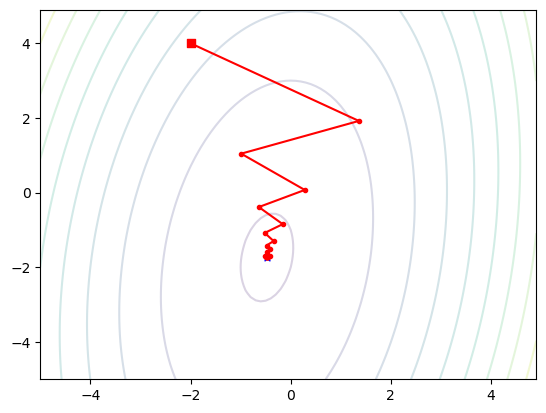

In [11]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, stretched_quad_obj.value, 
                  steepest_descent(stretched_quad_obj.value, stretched_quad_obj.grad, np.array([-2.0,4.0])),
                  -5, 5, -5, 5)

### Newton

Iteration sequence:
[array([-2.,  0.]), array([ 2., -4.]), array([ 2., -4.])]


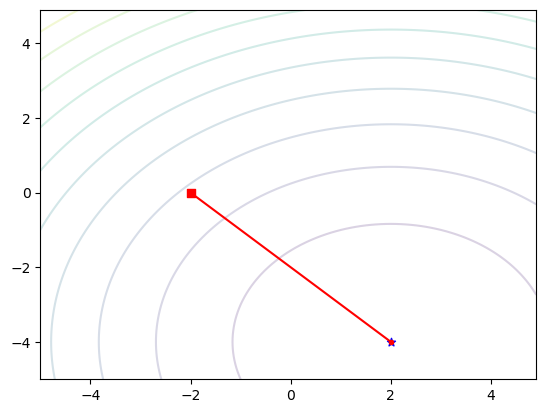

In [12]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, simple_quad_obj.value, 
                  newton(simple_quad_obj.value, simple_quad_obj.grad, simple_quad_obj.hess, np.array([-2.0,0.0])),
                  -5, 5, -5, 5)

Iteration sequence:
[array([-2.,  4.]), array([-0.47368421, -1.73684211]), array([-0.47368421, -1.73684211])]


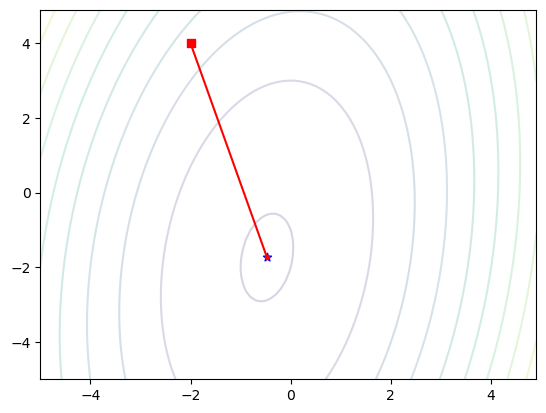

In [13]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, stretched_quad_obj.value, 
                  newton(stretched_quad_obj.value, stretched_quad_obj.grad, stretched_quad_obj.hess, np.array([-2.0,4.0])),
                  -5, 5, -5, 5)

# CVXOPT-SVM

There is an in-built, but we'll do it ourselves this time.

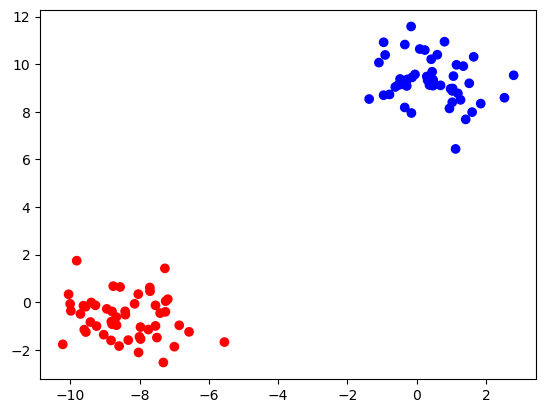

In [24]:
(samples, classifications) = sklearn.datasets.make_blobs(centers=2)
classifications = np.array([2 * float(c) - 1 for c in classifications]) #Map (0,1) to (-1,1)
plt.scatter(samples[:,0], samples[:,1], c=['red' if c < 0 else 'blue' for c in classifications])

     pcost       dcost       gap    pres   dres
 0: -9.7248e-04  1.9603e+00  3e+02  2e+00  8e+02
 1:  1.1459e+00 -3.2979e+00  5e+00  2e-02  1e+01
 2:  4.8896e-01 -2.0553e-01  7e-01  2e-03  9e-01
 3:  6.1741e-02 -1.5743e-02  8e-02  2e-04  9e-02
 4:  4.1846e-03  8.7515e-04  3e-03  2e-06  8e-04
 5:  2.6423e-03  1.5377e-03  1e-03  6e-07  3e-04
 6:  2.7277e-03  2.0256e-03  7e-04  2e-07  1e-04
 7:  2.3559e-03  2.3267e-03  3e-05  7e-09  3e-06
 8:  2.3417e-03  2.3412e-03  5e-07  1e-10  5e-08
 9:  2.3414e-03  2.3414e-03  1e-08  1e-12  5e-10
Optimal solution found.


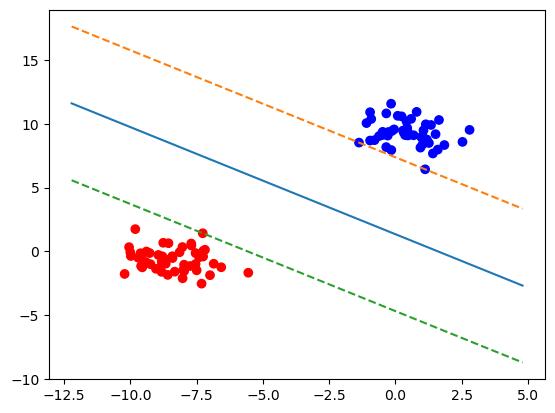

In [25]:
import cvxopt

def do_svm_primal(samples, classifications, mu=1.0):
    #As shown on the board we'll build the matrices we need
    var_len = 3 + len(samples)
    
    # Make objective
    p = np.zeros((var_len, var_len))
    p[0,0] = mu
    p[1,1] = mu
    q = np.zeros(var_len)
    q[3:] = 1.0/len(samples)
    
    # First part of the inequalities - nonnegativity
    upper_g = np.zeros((len(samples), var_len))
    upper_g[:,3:] = - np.eye(len(samples))
    
    # Second part - classification
    lower_g = np.copy(upper_g) #Last bit has same structure
    lower_g[:,0] = -classifications * samples[:,0]
    lower_g[:,1] = -classifications * samples[:,1]
    lower_g[:,2] = np.copy(classifications)
    
    g = np.vstack((upper_g, lower_g))
    h = np.hstack((np.zeros(len(samples)), -np.ones(len(samples))))
    
    # Now let's make the CVX format
    P = cvxopt.matrix(p)
    Q = cvxopt.matrix(q)
    G = cvxopt.matrix(g)
    H = cvxopt.matrix(h)
    
    sol = cvxopt.solvers.qp(P, Q, G, H)
    sol_ar = np.array(sol['x'])
    beta = np.copy(sol_ar[:2])
    alpha = sol_ar[2]
    
    return (beta, alpha)
    
beta, alpha = do_svm_primal(samples, classifications, 0.1)

plt.scatter(samples[:,0], samples[:,1], c=['red' if c < 0 else 'blue' for c in classifications])
xlow = np.min(samples[:,0]) - 2.0
xhigh = np.max(samples[:,0]) + 2.0
if (np.abs(beta[1]) > 1e-3): # or vertical
    xs = np.linspace(xlow, xhigh)
    ys = (alpha - beta[0]*xs)/beta[1]
    plt.plot(xs,ys)
    
    upper_ys = (1 + alpha - beta[0]*xs)/beta[1]
    plt.plot(xs, upper_ys, '--')
    lower_ys = (-1 + alpha - beta[0]*xs)/beta[1]
    plt.plot(xs, lower_ys, '--')
else:
    plt.axvline(alpha/beta[0])

# SVM with (stochastic) (sub)gradient methods

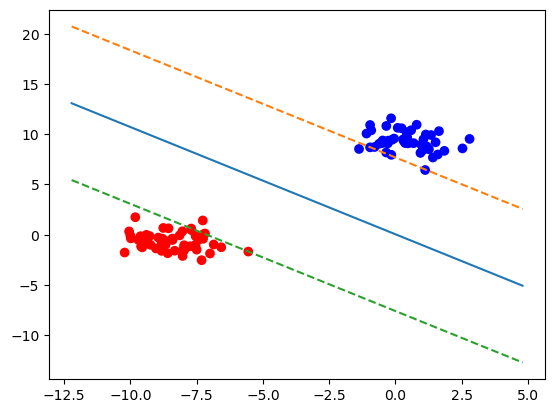

In [26]:
# We want to do the same with subgradient descent:

def f(beta, alpha, mu, samples, classifications):
    n = len(samples)
    
    val = mu * 0.5 * np.dot(beta, beta)
    for i in range(n):
        val += 1.0/n * np.max((0.0, 1.0 - classifications[i] * (np.dot(beta, samples[i]) - alpha)))
    return val

def f_subgr(beta, alpha, mu, samples, classifications):
    n = len(samples)
    
    beta_subgr = mu * beta
    alpha_subgr = 0.0
    for i in range(n): # Now it matters where we are at in the max
        if classifications[i] * (np.dot(beta, samples[i]) - alpha) < 1:
            beta_subgr += 1.0/n * (-classifications[i] * samples[i])
            alpha_subgr += 1.0/n * classifications[i]
        # Else 0!
    return (beta_subgr, alpha_subgr)
        

def do_subgr(samples, classifications, iters, mu = 1.0):
    # Initialization
    beta_init = np.array([0.0, 0.0])
    alpha_init = 0.0
    
    betas = [beta_init]
    alphas = [alpha_init]
    
    best_beta = np.copy(beta_init)
    best_alpha = np.copy(alpha_init)
    best_f = f(best_beta, best_alpha, mu, samples, classifications)
    
    n = len(samples)
    
    # We'll ignore the stopping criterion here
    for k in range(0, iters): # Actually k - 1 compared to the slides
        step_size = 0.1
        (beta_step, alpha_step) = f_subgr(betas[-1], alphas[-1], mu, samples, classifications) 

        #Step in negative of subgradient direction
        beta = betas[-1] - step_size * beta_step
        alpha = alphas[-1] - step_size * alpha_step
        
        betas.append(beta)
        alphas.append(alpha)
        
        # But was this any good?
        cand_f = f(beta, alpha, mu, samples, classifications)
        if cand_f < best_f:
            best_beta = np.copy(beta)
            best_alpha = np.copy(alpha)
            best_f = cand_f
    
    return (best_beta, best_alpha)

(beta, alpha) = do_subgr(samples, classifications, 1000, 1.0)

plt.scatter(samples[:,0], samples[:,1], c=['red' if c < 0 else 'blue' for c in classifications])
xlow = np.min(samples[:,0]) - 2.0
xhigh = np.max(samples[:,0]) + 2.0
if (np.abs(beta[1]) > 1e-3): # or vertical
    xs = np.linspace(xlow, xhigh)
    ys = (alpha - beta[0]*xs)/beta[1]
    plt.plot(xs,ys)
    # Draw classification boundaries
    upper_ys = (1 + alpha - beta[0]*xs)/beta[1]
    plt.plot(xs, upper_ys, '--')
    lower_ys = (-1 + alpha - beta[0]*xs)/beta[1]
    plt.plot(xs, lower_ys, '--')
else:
    plt.axvline(alpha/beta[0])

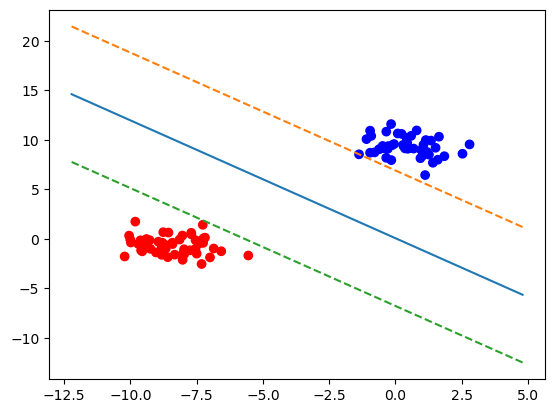

In [29]:
# And with stochastic subgradient descent

def f_subgr_comp(i, beta, alpha, mu, samples, classifications):
    n = len(samples)
    
    beta_subgr = mu * beta
    alpha_subgr =  0.0
    if classifications[i] * (np.dot(beta, samples[i]) - alpha) < 1:
        beta_subgr += (-classifications[i] * samples[i])
        alpha_subgr += classifications[i]
    # Else 0!
    return (beta_subgr, alpha_subgr)
        

def do_subgr_stoch(samples, classifications, iters, mu = 1.0):
    # Initialization
    beta_init = np.array([0.0, 0.0])
    alpha_init = 0.0
    
    #betas = [beta_init]
    #alphas = [alpha_init]
    beta = np.copy(beta_init)
    alpha = np.copy(alpha_init)
    
    
    best_beta = np.copy(beta_init)
    best_alpha = np.copy(alpha_init)
    best_f = f(best_beta, best_alpha, mu, samples, classifications)
    
    n = len(samples)
    
    # We'll ignore the stopping criterion here
    for k in range(0, iters): # Actually k - 1 compared to the slides
        step_size = 0.01
        sample_index = np.random.randint(n)
        (beta_step, alpha_step) = f_subgr_comp(sample_index, beta, alpha, mu, samples, classifications) 

        #Step in negative of subgradient direction
        beta = beta - step_size * beta_step
        alpha = alpha - step_size * alpha_step
        
        #betas.append(beta)
        #alphas.append(alpha)
        
        # But was this any good?
        cand_f = f(beta, alpha, mu, samples, classifications)
        if cand_f < best_f:
            best_beta = np.copy(beta)
            best_alpha = np.copy(alpha)
            best_f = cand_f
    
    return (best_beta, best_alpha)

(beta, alpha) = do_subgr_stoch(samples, classifications, 2000, 0.1)

plt.scatter(samples[:,0], samples[:,1], c=['red' if c < 0 else 'blue' for c in classifications])
xlow = np.min(samples[:,0]) - 2.0
xhigh = np.max(samples[:,0]) + 2.0
if (np.abs(beta[1]) > 1e-3): # or vertical
    xs = np.linspace(xlow, xhigh)
    ys = (alpha - beta[0]*xs)/beta[1]
    plt.plot(xs,ys)
    # Draw classification boundaries
    upper_ys = (1 + alpha - beta[0]*xs)/beta[1]
    plt.plot(xs, upper_ys, '--')
    lower_ys = (-1 + alpha - beta[0]*xs)/beta[1]
    plt.plot(xs, lower_ys, '--')
else:
    plt.axvline(alpha/beta[0])

# Simple neural network

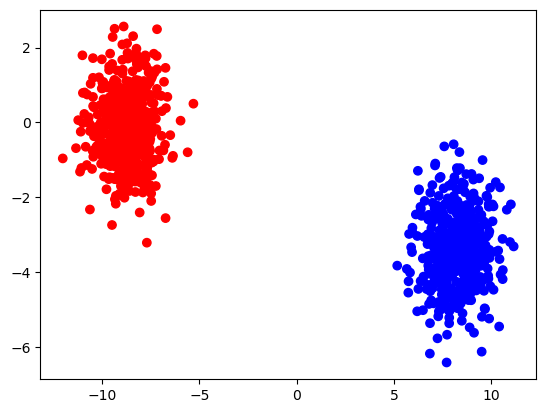

In [21]:
(samples, classifications) = sklearn.datasets.make_blobs(n_samples=1000, centers=2)
plt.scatter(samples[:,0], samples[:,1], c=['red' if c == 0 else 'blue' for c in classifications])

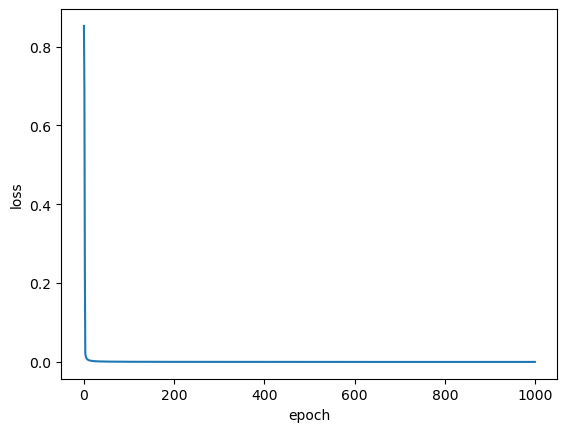

0.0


/tmp/ipykernel_512/3531207503.py:35: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(np.sum(np.abs(a - b) for (a,b) in zip(np.round(test_output), classifications[600:])))


In [22]:
#Stupidly simplified

model = torch.nn.Sequential(torch.nn.Linear(2, 1),
                            torch.nn.Sigmoid())
loss = torch.nn.MSELoss()
sgd_opt = torch.optim.SGD(model.parameters(), lr=0.1) #Learning rate should be low, 
# Our friend SGD!!

train_input = torch.tensor(samples[:600,:])
train_output = torch.reshape(torch.tensor(classifications[:600]), (600,1))

losses = []
for epoch in range(1000):
    sgd_opt.zero_grad() #Technical
    
    # Find the objective
    pred_y = model(train_input.float())
    iter_loss = loss(pred_y, train_output.float())
    # Store it
    losses.append(iter_loss.item())
    

    iter_loss.backward() #Find gradients
    
    sgd_opt.step()

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

model.eval()
test_input = torch.tensor(samples[600:,:])
test_output = model(test_input.float()).detach().numpy().flatten()
print(np.sum(np.abs(a - b) for (a,b) in zip(np.round(test_output), classifications[600:])))

# Outer-approximation algorithm for SVM support



In [20]:
def inner_comp(X, Y, s, gamma):
    print('Inner loop')
    # Solve the maximization problem in Bertsimas-Dunn as a QP
    (n, p) = np.shape(X)
    
    # Build objective
    P_np = np.zeros((n, n))
    for j in range(p):
        P_np += gamma * s[j] * np.outer(X[:,j], X[:,j]) # 1/2 comes from cvxopt here
    q_np = Y
    
    P = cvxopt.matrix(P_np)
    q = cvxopt.matrix(q_np)
       
    # Build constraints
    G_np = np.vstack((np.diag(Y), -np.diag(Y)))
    h_np = np.vstack((np.zeros((n,1)), np.ones((n,1))))
    
    G = cvxopt.matrix(G_np)
    h = cvxopt.matrix(h_np)
    
    # Equality constraint
    #A_np = np.ones((1,n))
    #b_np = np.zeros((1,1))
    #A = cvxopt.matrix(A_np)
    #b = cvxopt.matrix(b_np)
   # 
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(P, q, G, h)#, A, b)
    #print(sol)
    
    sol_ar = np.array(sol['x'])
    #print(sol_ar)
    #raise 'Hell'
    
    # Now we'll do the gradient too
    grad = np.zeros((p,1))
    for j in range(p):
        outer = np.dot(X[:,j], X[:,j].T)
        grad[j] = - (gamma / 2.0) * np.dot(sol_ar.T, np.dot(outer, sol_ar))
    
    # Remember to multiply objective by -1!
    #print(grad)
    return (-sol['primal objective'], grad)
    
def find_plane(cs, grads, ss, s, k, gamma):
    p = len(s)
    t = len(cs)
    
    model = pe.ConcreteModel()
    
    # Two variables
    model.eta = pe.Var()
    model.s = pe.Var(range(p), domain=pe.Binary, bounds=(0,1))
    # Objective is easy enough
    model.obj = pe.Objective(expr = 1.0 * model.eta, sense = pe.minimize)
    
    # Constraints are harder
    model.constraints = pe.ConstraintList()
    for i in range(t):
        model.constraints.add(model.eta >= cs[i] + sum(grads[i][j] * (model.s[j] - ss[i][j]) for j in range(p)))
    # Also need to enforce the k constraint
    model.constraints.add(sum(model.s[j] for j in range(p)) <= k)
    
    results = pe.SolverFactory('glpk').solve(model, tee=False)
    #results.write()
    if results.solver.status:
        print('Cut plane completed. Solution:')
        print(f'Eta: {model.eta.value}')
        s = np.zeros(p)
        for i in range(p):
            s[i] = model.s[i].value
        print(f's: {s}')
    else: 
        raise 'Another disaster'    
    
    return (model.eta.value, s)
        
def outer_approximation(X, Y, k, beta_init, gamma):
    print('Beginning outer approximation.')
    s = np.copy(beta_init)
    ss = [s]
    t = 0
    eta = 0
    (c, grad) = inner_comp(X, Y, s, gamma)
    cs = [c]
    grads = [grad]
    
    while t < 10: # Just a safeguard on the implementation
        # Find new plane 
        eta, s = find_plane(cs, grads, ss, s, k, gamma)
        # Evaluate it
        (c, grad) = inner_comp(X, Y, s, gamma)
        
        # Update for next iteration
        ss.append(s)
        cs.append(c)
        grads.append(grad)
        
        t += 1
        
        if np.abs(cs[-1] - cs[-2]) < 1e-7:
            break
    print(f'Outer-approximation terminated after {t} iterations.')
    print(cs)
    print(ss)
    return s

In [21]:
features = 50
n = 1000
p = features + 1 # To account for the extra column later on
(samples, classifications) = sklearn.datasets.make_blobs(n_samples=n, centers=2, n_features=features)
Y = np.array([2 * float(c) - 1 for c in classifications]) #Map (0,1) to (-1,1)

#Let's add one dimension to the problem
X = np.hstack((samples, -np.ones((n,1))))

def count_classif(beta, X, Y):
    raw_classes = np.dot(X, beta)
    return np.sum(np.sign(raw_classes) == np.sign(Y))

In [22]:
k = 3 #Why not
gamma = 1.0/(np.max(np.linalg.norm(X, axis=1))**2)
#gamma = 100
test_beta = np.zeros(p)
#test_beta[21:k+21] = 1
#test_beta[9:11] = 1

s_final = outer_approximation(X, Y, k, test_beta, gamma)
print('')
print(f'gamma: {gamma}')
print(f'Original classification power: {count_classif(test_beta,X,Y)}')
print(test_beta)
print(f'Ultimate classification power: {count_classif(s_final, X, Y)}')
print(s_final)

Beginning outer approximation.
Inner loop
Cut plane completed. Solution:
Eta: -55276.8215586135
s: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0.]
Inner loop
Cut plane completed. Solution:
Eta: 10.1307033011881
s: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0.]
Inner loop
Outer-approximation terminated after 2 iterations.
[999.9999838821125, 10.130703301187747, 10.130703301187747]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0

In [98]:
Y[10:20]

array([-1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1.])

In [99]:
np.dot(X, s_final)[10:20]

array([ 9.30084458,  9.77604384, 11.18270991, 10.782007  , 14.7976533 ,
       12.66018931, 12.71647601,  7.54038497, 10.29568214,  9.43943155])